Follows $\texttt{https://github.com/ericmetodiev/OmniFold/blob/master/OmniFold\%20Demo.ipynb}$ but uses pip-installable version of OmniFold

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

import energyflow as ef # for data
import omnifold # for omnifold algorithm

# Local imports for plotting (source: https://github.com/ericmetodiev/OmniFold/blob/master/modplot.py)
import modplot
from hist_utils import obs, calc_obs, hist_style, gen_style, truth_style, ibu_style, omnifold_style

plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'serif'

# Global variables
LAYER_SIZES = [64, 128, 64]
OBS_MULTIFOLD = ['Mass', 'Mult', 'Width', 'Tau21', 'zg', 'SDMass']
N_DATA = int(1e5)
N_ITER = 3
BATCH_SIZE = 500
EPOCHS = 2
N_JOBS = 16

np.random.seed(0)
import tensorflow as tf
tf.random.set_seed(0)

2025-03-24 17:43:27.444536: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-24 17:43:28.648680: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-24 17:43:28.652169: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-24 17:43:35.579926: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Horovod not found, will continue with single only GPUs.


# Load data

We assume, for simplicity:
1. That everything passes the reco and gen cuts
2. That the data is already normalized
3. That the data is uniformly weighted, to begin

We choose Pythia as the Monte Carlo data

In [2]:
data_mc_dict = ef.zjets_delphes.load('Pythia26', num_data=N_DATA, exclude_keys=['particles'])
data_mc_gen = {k.replace("gen_", ""): data_mc_dict[k] for k in data_mc_dict.keys() if 'gen_' in k}
data_mc_sim= {k.replace("sim_", ""): data_mc_dict[k] for k in data_mc_dict.keys() if 'sim_' in k}

data_mc_gen['Mass'] = data_mc_gen['jets'][:,3]
data_mc_gen.pop('jets')
data_mc_gen['Mult'] = data_mc_gen.pop('mults')
data_mc_gen['Width'] = data_mc_gen.pop('widths')
data_mc_gen['Tau21'] = data_mc_gen.pop('tau2s')
data_mc_gen['zg'] = data_mc_gen.pop('zgs')
data_mc_gen['SDMass'] = data_mc_gen.pop('sdms')
data_mc_gen = np.concatenate([data_mc_gen[k].reshape((N_DATA,1)) for k in OBS_MULTIFOLD], axis=1)

data_mc_sim['Mass'] = data_mc_sim['jets'][:,3]
data_mc_sim.pop('jets')
data_mc_sim['Mult'] = data_mc_sim.pop('mults')
data_mc_sim['Width'] = data_mc_sim.pop('widths')
data_mc_sim['Tau21'] = data_mc_sim.pop('tau2s')
data_mc_sim['zg'] = data_mc_sim.pop('zgs')
data_mc_sim['SDMass'] = data_mc_sim.pop('sdms')
data_mc_sim = np.concatenate([data_mc_sim[k].reshape((N_DATA,1)) for k in OBS_MULTIFOLD], axis=1)

# Create DataLoader object
data_mc = omnifold.DataLoader(reco=data_mc_sim, gen=data_mc_gen)


INFO: Creating weights ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...


And Hedwig as the true/nature data

In [3]:
data_nature_dict = ef.zjets_delphes.load('Herwig', num_data=N_DATA, exclude_keys=['particles'])
data_nature_gen = {k.replace("gen_", ""): data_nature_dict[k] for k in data_nature_dict.keys() if 'gen_' in k}
data_nature_sim= {k.replace("sim_", ""): data_nature_dict[k] for k in data_nature_dict.keys() if 'sim_' in k}

data_nature_gen['Mass'] = data_nature_gen['jets'][:,3]
data_nature_gen.pop('jets')
data_nature_gen['Mult'] = data_nature_gen.pop('mults')
data_nature_gen['Width'] = data_nature_gen.pop('widths')
data_nature_gen['Tau21'] = data_nature_gen.pop('tau2s')
data_nature_gen['zg'] = data_nature_gen.pop('zgs')
data_nature_gen['SDMass'] = data_nature_gen.pop('sdms')
data_nature_gen = np.concatenate([data_nature_gen[k].reshape((N_DATA,1)) for k in OBS_MULTIFOLD], axis=1)

data_nature_sim['Mass'] = data_nature_sim['jets'][:,3]
data_nature_sim.pop('jets')
data_nature_sim['Mult'] = data_nature_sim.pop('mults')
data_nature_sim['Width'] = data_nature_sim.pop('widths')
data_nature_sim['Tau21'] = data_nature_sim.pop('tau2s')
data_nature_sim['zg'] = data_nature_sim.pop('zgs')
data_nature_sim['SDMass'] = data_nature_sim.pop('sdms')
data_nature_sim = np.concatenate([data_nature_sim[k].reshape((N_DATA,1)) for k in OBS_MULTIFOLD], axis=1)

# Create DataLoader object
data_nature = omnifold.DataLoader(reco=data_nature_sim, gen=data_nature_gen)


INFO: Creating weights ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...


In [4]:
calc_obs(obs_dict=obs, data_synth=data_mc_dict, data_real=data_nature_dict)

Done with Mass
Done with Mult
Done with Width
Done with Tau21
Done with zg
Done with SDMass


# Construct MultiFold object

In [5]:
name = "MultiFold"
model_reco = omnifold.net.MLP(nvars = len(OBS_MULTIFOLD), layer_sizes=LAYER_SIZES)
model_gen = omnifold.net.MLP(nvars = len(OBS_MULTIFOLD), layer_sizes=LAYER_SIZES)
data = data_nature
mc = data_mc
model = omnifold.MultiFold(
    name=name, 
    model_reco=model_reco, 
    model_gen=model_gen, 
    data=data, 
    mc=mc, 
    niter=N_ITER,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    size=N_JOBS)

25 training steps at reco and 25 steps at gen


2025-03-24 17:43:53.549340: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Unfold

In [6]:
model.Unfold()

ITERATION: 1
RUNNING STEP 1
Last val loss 0.7028079032897949
INFO: Dumping training history ...
RUNNING STEP 2
Last val loss 0.7354559302330017
INFO: Dumping training history ...
ITERATION: 2
RUNNING STEP 1
Last val loss 0.7326143980026245
INFO: Dumping training history ...
RUNNING STEP 2
Last val loss 0.7226529717445374
INFO: Dumping training history ...
ITERATION: 3
RUNNING STEP 1
Last val loss 0.7340794801712036
INFO: Dumping training history ...
RUNNING STEP 2
Last val loss 0.6723301410675049
INFO: Dumping training history ...


# Evaluate

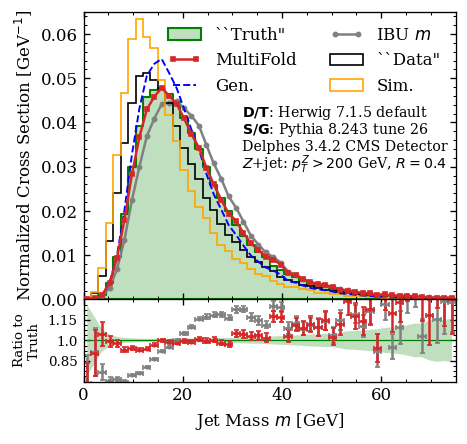

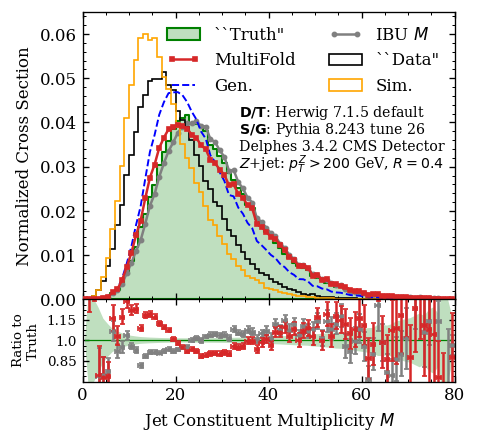

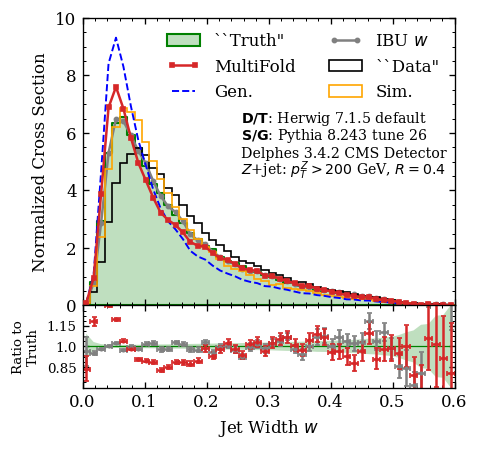

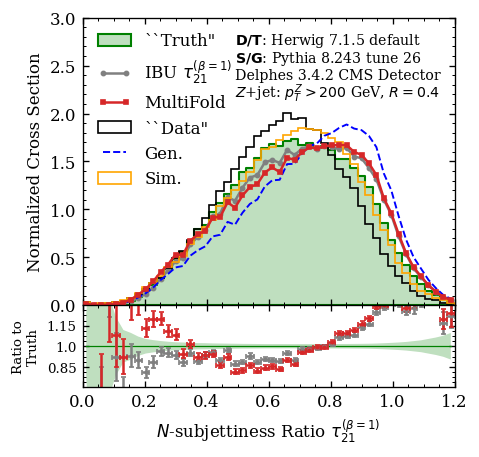

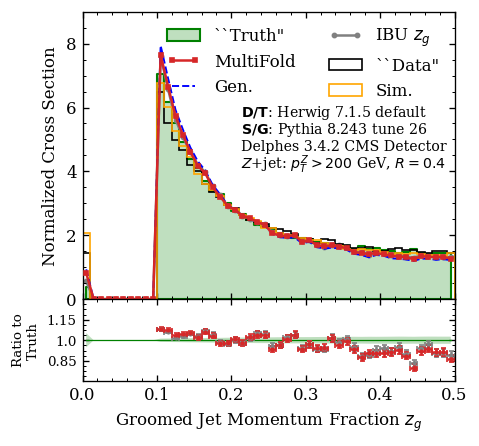

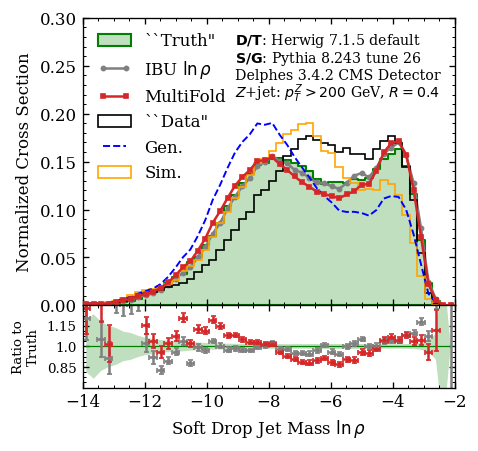

In [7]:
for i,(obkey,ob) in enumerate(obs.items()):
    
    # get the styled axes on which to plot
    fig, [ax0, ax1] = modplot.axes(**ob)
    if ob.get('yscale') is not None:
        ax0.set_yscale(ob['yscale'])
        
    # Plot the Different Distributions of the Observable
    # plot the "data" histogram of the observable
    ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='``Data\"', **hist_style)

    # plot the "sim" histogram of the observable
    ax0.hist(ob['simobs'], bins=ob['bins_det'], color='orange', label='Sim.', **hist_style)

    # plot the "gen" histogram of the observable
    ax0.plot(ob['midbins_mc'], ob['genobs_hist'], **gen_style)

    # plot the "truth" histogram of the observable
    ax0.fill_between(ob['midbins_mc'], ob['truth_hist'], **truth_style)
    
    # Plot the Unfolded Distributions of the Observable
    # plot the OmniFold distribution
    of_histgen, of_histgen_unc = modplot.calc_hist(ob['genobs'], weights=model.weights_push, 
                                                   bins=ob['bins_mc'], density=True)[:2]
    ax0.plot(ob['midbins_mc'], of_histgen, **omnifold_style, label='MultiFold')

    # plot the IBU distribution
    ax0.plot(ob['midbins_mc'], ob['ibu_phis'][N_ITER], **ibu_style, label='IBU ' + ob['symbol'])

    # Plot the Ratios of the OmniFold and IBU distributions to truth (with statistical uncertainties)
    ibu_ratio = ob['ibu_phis'][N_ITER]/(ob['truth_hist'] + 10**-50)
    of_ratio = of_histgen/(ob['truth_hist'] + 10**-50)
    ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)
    
    # ratio uncertainties
    truth_unc_ratio = ob['truth_hist_unc']/(ob['truth_hist'] + 10**-50)
    ibu_unc_ratio = ob['ibu_phi_unc']/(ob['truth_hist'] + 10**-50)
    of_unc_ratio = of_histgen_unc/(ob['truth_hist'] + 10**-50)
    
    ax1.fill_between(ob['midbins_mc'], 1 - truth_unc_ratio, 1 + truth_unc_ratio, 
                     facecolor=truth_style['facecolor'], zorder=-2)
    ax1.errorbar(ob['midbins_mc'], ibu_ratio, xerr=ob['binwidth_mc']/2, yerr=ibu_unc_ratio, 
                                              color=ibu_style['color'], **modplot.style('errorbar'))
    ax1.errorbar(ob['midbins_mc'], of_ratio, xerr=ob['binwidth_mc']/2, yerr=of_unc_ratio, 
                                              color=omnifold_style['color'], **modplot.style('errorbar'))

    # legend style and ordering
    loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
    order = [3, 4, 2, 5, 0, 1] if ncol==2 else [3, 5, 4, 0, 2, 1]
    modplot.legend(ax=ax0, frameon=False, order=order, loc=loc, ncol=ncol)

    # stamp to put on the plots
    modplot.stamp(*ob['stamp_xy'], delta_y=0.06, ax=ax0,
                  line_0=r'$\mathbf{D/T}$: Herwig 7.1.5 default',
                  line_1=r'$\mathbf{S/G}$: Pythia 8.243 tune 26',
                  line_2=r'Delphes 3.4.2 CMS Detector',
                  line_3=r'$Z$+jet: $p_T^Z>200$ GeV, $R=0.4$')
    
    # save plot (by default in the same directory as this notebook).
    # If running on binder, the plot can be accessed by first going to the jupyter file browser
    # (which itself can be accessed by copying the URL of this notebook and removing the name of the notebook
    # after the final "/"), selecting the square next to the name of the plot, and clicking "Download".
    fig.savefig('MultiFold_{}.pdf'.format(obkey), bbox_inches='tight')
    plt.show()

In [8]:
model.model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,089 (66.75 KB)

 Trainable params: 17,089 (66.75 KB)

 Non-trainable params: 0 (0.00 B)